# Monitoring Polk County, Iowa

Groundwater level is an important metric, especially for agriculture states such as Iowa. One of the metrics [U.S. Geological Survey (USGS)](https://www.usgs.gov/) monitors is **depth to water level in feet below the land**. In this lab we will use a synthetic dataset that models certain scenarios for Polk County, Iowa. 

## Lab Scenario

This notebook is an optional prequel to the next notebook ` anomaly_detection_lab2_2.ipynb`. In this notebook we will introduce you to the 92 locations within Polk County Iowa where we have placed the sensors to collect the three-key weather-related on a daily basis:

- water-level (depth to water level in feet below the land)
- temperature
- humidity

The data is generated daily using realistic monthly averages for Polk County, Iowa, for the years 2017 – 2019. The data is generated daily for each of the 92 different sensors within Polk County, Iowa – 3 years x 365 days x 92 sensors = 100,740 total sets of data.

We are going to be using 2 copies of the dataset for years 2017 -2019: 

1. Normal conditions for the county.
2. A gradual build up dry conditions in one of the regions in Polk County, Iowa over the months of June and July 2019.

The overall goal of the lab-2 is to develop an approach to monitor a group of sensors based on their proximity to each other to predict regional anomalies in real-time. Thus, in this notebook we will be using K-Means clustering algorithm to create 6 different clusters of the 92 individual locations based on location proximity using the latitude and longitude information for each location. The clusters we create in this notebook, will be used in the next notebook as one of the model features.

In this notebook, we will also load the two datasets – normal and gradual, to review the features and patterns that can be observed in those datasets using standard techniques.

## Outline

1. **Setup**: Import required libaries and download the required shapefiles.

2. **Overview of Polk County, Iowa Locations**: Visualize the Polk County locations on a map.

3. **Create location clusters based on proximity (latitude and longitude)**: Use the K-Means clustering algorithm to create proximity-based clusters.

4. **Introduction to the datasets**: Review the features and patterns in the datasets.

### Import required libraries 

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import os
import math
from IPython.display import display, HTML, Image, SVG
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
print("pandas version: {} numpy version: {}".format(pd.__version__, np.__version__))

import sklearn
from sklearn.cluster import KMeans

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

print('importing libraries done!')

pandas version: 0.25.1 numpy version: 1.16.4
importing libraries done!


### Helper method to display a pandas dataframe

In [2]:
def display_dataframe(df_in):
    s = df_in.style.set_properties(**{'text-align': 'left'})
    s.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(HTML(s.render()))

### Download Polk County, Iowa shapefiles

In [3]:
faces_files = ['tl_2018_19153_faces.shp.iso.xml', 'tl_2018_19153_faces.prj', 'tl_2018_19153_faces.dbf', 
               'tl_2018_19153_faces.shp.ea.iso.xml', 'tl_2018_19153_faces.shx', 'tl_2018_19153_faces.cpg', 
               'tl_2018_19153_faces.shp']
area_water_files = ['tl_2019_19153_areawater.dbf', 'tl_2019_19153_areawater.shp.iso.xml', 
                    'tl_2019_19153_areawater.cpg', 'tl_2019_19153_areawater.shp', 
                    'tl_2019_19153_areawater.shp.ea.iso.xml', 'tl_2019_19153_areawater.shx', 
                    'tl_2019_19153_areawater.prj']

faces_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
             'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
             'anomaly_detection/counties/shapefiles/tl_2018_19153_faces/')

area_water_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
                  'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
                  'anomaly_detection/counties/shapefiles/tl_2019_19153_areawater/')

os.makedirs('./shapefiles/faces', exist_ok=True)
os.makedirs('./shapefiles/areawater', exist_ok=True)

for i in range(len(faces_files)):
    file_url = faces_url + faces_files[i]
    urllib.request.urlretrieve(file_url, ('./shapefiles/faces/' + faces_files[i]))

for i in range(len(area_water_files)):
    file_url = area_water_url + area_water_files[i]
    urllib.request.urlretrieve(file_url, ('./shapefiles/areawater/' + area_water_files[i]))
    
print('Done downloading shapefiles for Polk county, Iowa!')

Done downloading shapefiles for Polk county, Iowa!


## Overview of Polk County, Iowa Locations

### Load the Polk County location data

In [5]:
polk_county_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
                   'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/'
                   'anomaly_detection/counties/polk_county.xlsx')

polk_county_df = pd.read_excel(polk_county_url)
polk_county_df.Longitude = -polk_county_df.Longitude

pc_faces_shape = './shapefiles/faces/tl_2018_19153_faces.shp'
pc_areawater_shape = './shapefiles/areawater/tl_2019_19153_areawater.shp'

pc_faces_df = gpd.read_file(pc_faces_shape)
pc_areawater_df = gpd.read_file(pc_areawater_shape)

print('Total number of locations in Polk County, Iowa: ', len(polk_county_df))

Total number of locations in Polk County, Iowa:  92


### Review the Polk County locations

In [4]:
display_dataframe(polk_county_df)

,State,StateCode,County,CountyCode,county_fips,City,Zip,Latitude,Longitude
0,IA,19,Polk,153,19153,Altoona,50009,41.6188,-93.4653
1,IA,19,Polk,153,19153,Altoona,50009,41.6313,-93.4658
2,IA,19,Polk,153,19153,Altoona,50009,41.6513,-93.4459
3,IA,19,Polk,153,19153,Altoona,50009,41.6467,-93.4855
4,IA,19,Polk,153,19153,Ankeny,50021,41.7438,-93.5909
5,IA,19,Polk,153,19153,Ankeny,50023,41.7455,-93.6035
6,IA,19,Polk,153,19153,Ankeny,50023,41.7021,-93.6289
7,IA,19,Polk,153,19153,Ankeny,50023,41.699,-93.6458
8,IA,19,Polk,153,19153,Ankeny,50023,41.7384,-93.6212
9,IA,19,Polk,153,19153,Ankeny,50023,41.7583,-93.6111


### Visualize the Polk County locations

Select the points on the map to see the **City** and **Zipcode** of the location

<IPython.core.display.Javascript object>


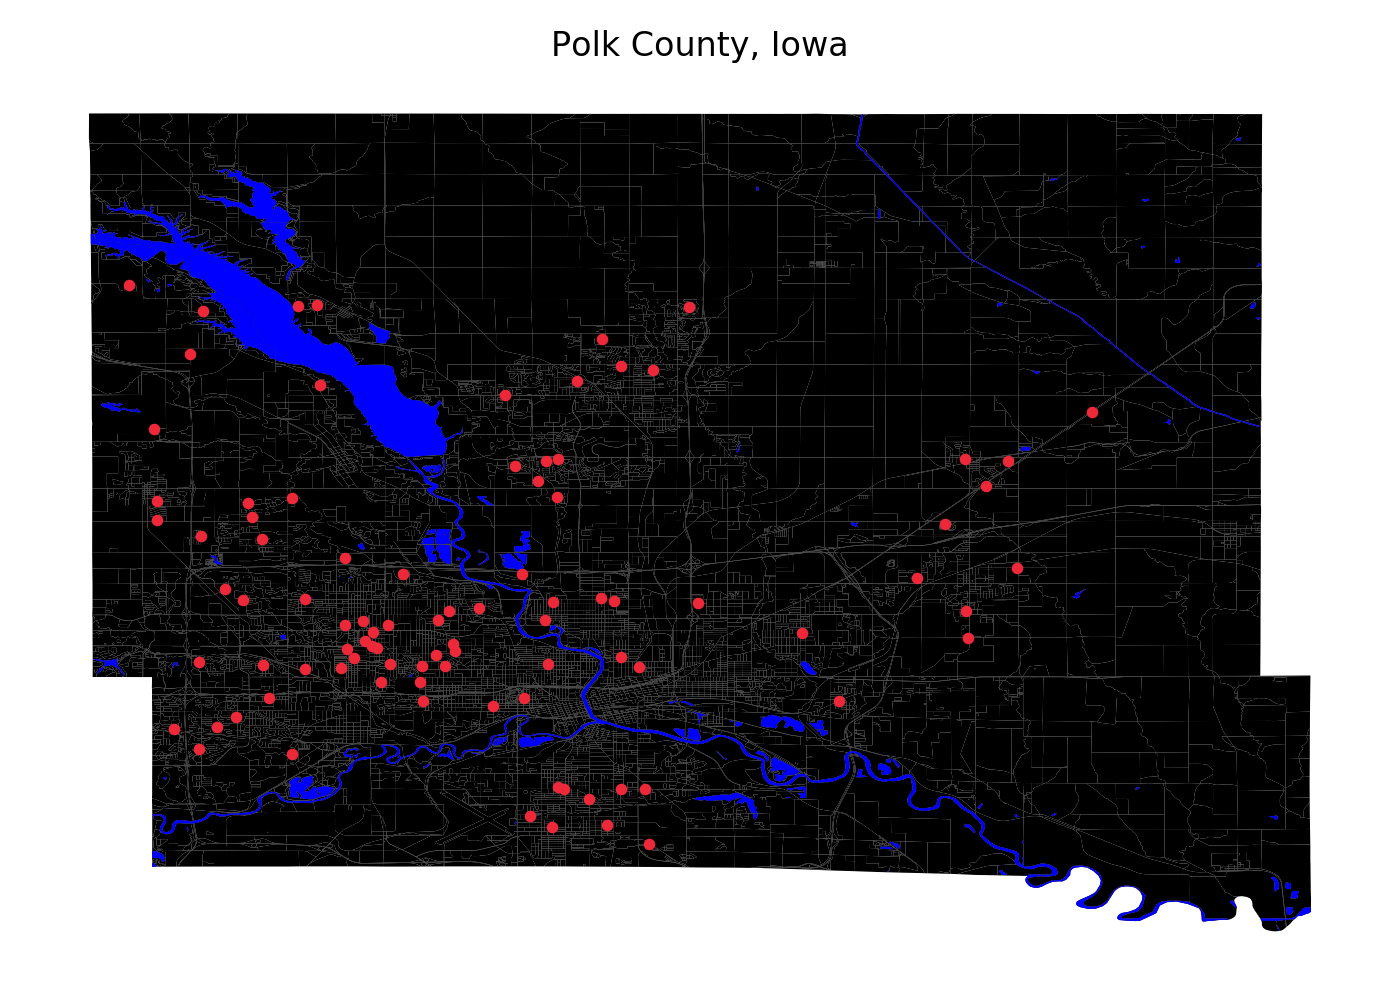

In [6]:
f, ax = plt.subplots(figsize=(7, 5))
pc_faces_df.plot(ax=ax, color='black', alpha=1.0)
pc_areawater_df.plot(ax=ax, color='blue')
geometry = [Point(xy) for xy in zip(polk_county_df['Longitude'], polk_county_df['Latitude'])]
pc_gdf = GeoDataFrame(polk_county_df, geometry=geometry)
sc = pc_gdf.plot(ax=ax, marker='o', color='#ED2939', markersize=10, picker=5)
ax.axis('off')
ax.set_title('Polk County, Iowa')

annot = ax.annotate("", xy=(0,0), xytext=(20, 20), textcoords="offset points", fontsize=8, 
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->", color='white'))
annot.set_visible(False)

def update_annot(coord):
    annot.xy = coord
    point = Point(coord[0], coord[1])
    row = polk_county_df[polk_county_df.geometry == point]
    text = 'City: {} Zip: {}'.format(row.City.values[0], row.Zip.values[0])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.8)
    
def onpick(event):
    vis = annot.get_visible()
    if vis:
        annot.set_visible(False)       
    art = event.artist
    index = event.ind
    xy = event.artist.get_offsets()
    update_annot(xy[index][0])
    annot.set_visible(True)
    f.canvas.draw_idle()
    
def onleave(event):
    annot.set_visible(False)

f.canvas.mpl_connect('figure_leave_event', onleave)
f.canvas.mpl_connect('pick_event', onpick)
f.tight_layout(rect=[0, 0, 1, 1], pad=1.0)

## Create location clusters based on proximity (latitude and longitude)

In [7]:
X = polk_county_df[['Longitude', 'Latitude']]

n_clusters = 6
km_model = KMeans(n_clusters=n_clusters, random_state=95)

cluster_id = km_model.fit_predict(X)

X['cluster_id'] = cluster_id

### Visualize the clusters

Select the points on the map to see the **City** and **Zipcode** of the location

<IPython.core.display.Javascript object>


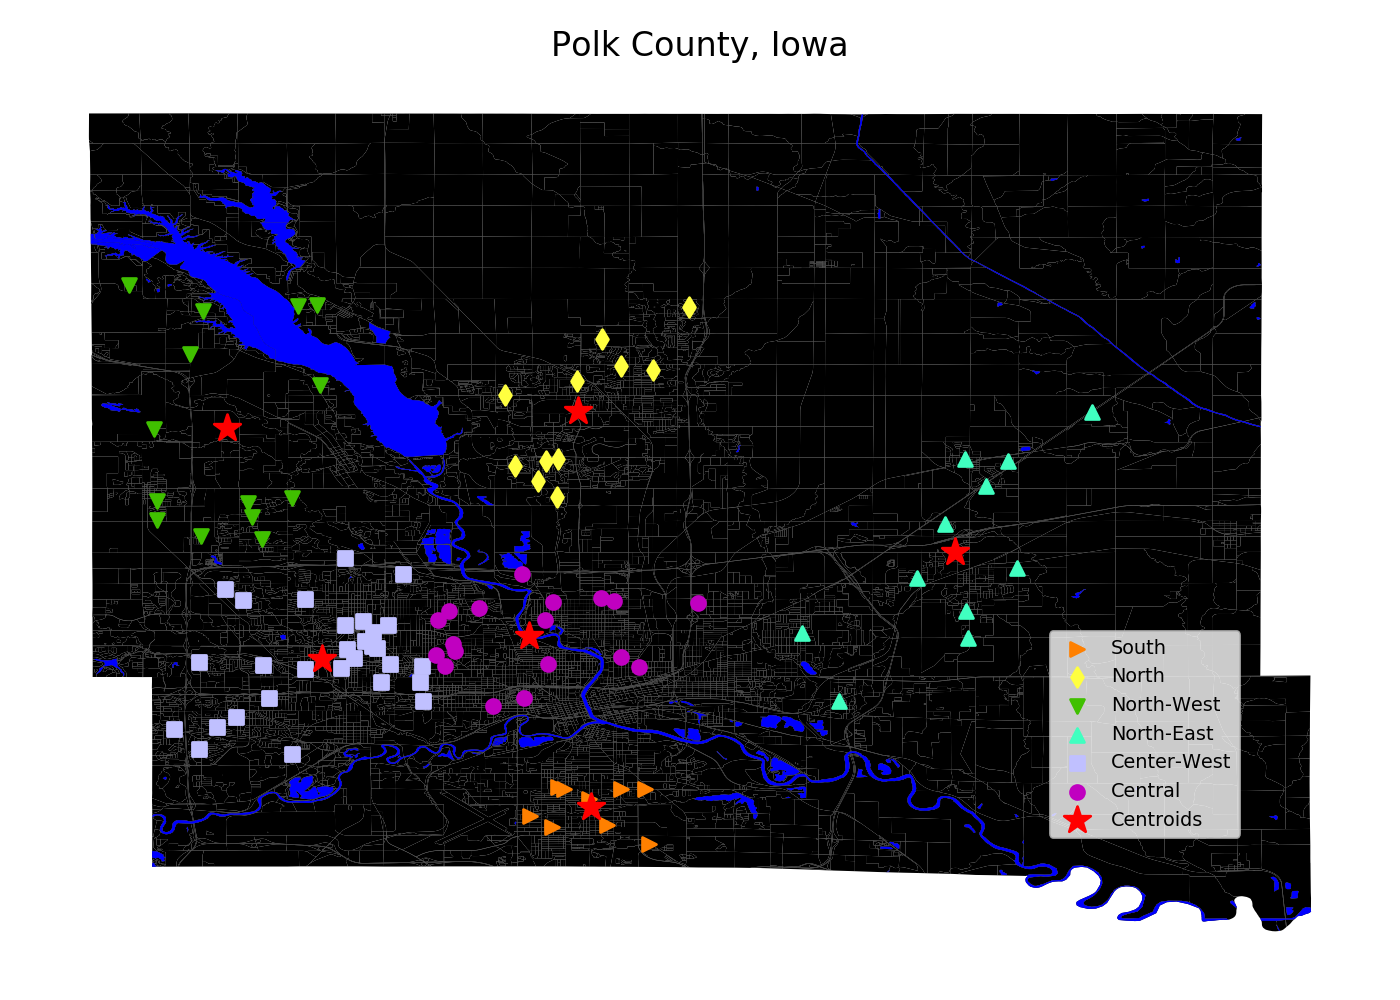

In [8]:
regions = ['South', 'North', 'North-West', 'North-East', 'Center-West', 'Central']

f, ax = plt.subplots(figsize=(7, 5))
pc_faces_df.plot(ax=ax, color='black', alpha=1.0)
pc_areawater_df.plot(ax=ax, color='blue')
geometry = [Point(xy) for xy in zip(polk_county_df['Longitude'], polk_county_df['Latitude'])]
pc_gdf = GeoDataFrame(polk_county_df, geometry=geometry)
ax.axis('off')
ax.set_title('Polk County, Iowa')

annot = ax.annotate("", xy=(0,0), xytext=(20, 20), textcoords="offset points", fontsize=8, 
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->", color='white'))
annot.set_visible(False)

def update_annot(coord):
    annot.xy = coord
    point = Point(coord[0], coord[1])
    row = polk_county_df[polk_county_df.geometry == point]
    text = 'City: {} Zip: {}'.format(row.City.values[0], row.Zip.values[0])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.8)
    
def onpick(event):
    vis = annot.get_visible()
    if vis:
        annot.set_visible(False)       
    art = event.artist
    index = event.ind
    xy = event.artist.get_offsets()
    update_annot(xy[index][0])
    annot.set_visible(True)
    f.canvas.draw_idle()
    
def onleave(event):
    annot.set_visible(False)

f.canvas.mpl_connect('figure_leave_event', onleave)
f.canvas.mpl_connect('pick_event', onpick)
f.tight_layout(rect=[0, 0, 1, 1], pad=1.0)

colors = ['#FF8000', '#FFFF40', '#40C000', '#40FFC0', '#C0C0FF', '#C000C0']
markers = ['>', 'd', 'v', '^', 's', 'o']

for i in range(n_clusters):
    plt.scatter(
        X[cluster_id == i]['Longitude'], X[cluster_id == i]['Latitude'],
        s=25, c=colors[i], marker=markers[i], label = regions[i], 
        picker=5
    )

# plot the centroids
plt.scatter(
    km_model.cluster_centers_[:, 0], km_model.cluster_centers_[:, 1],
    s=100, marker='*', c='red', label='Centroids'
)

plt.legend(frameon=True, fontsize='x-small', loc=(0.76, 0.15));

### Cluster Summary

In [8]:
X['region'] = X.cluster_id.apply(lambda x: regions[x])
X['centroid_lat'] = X.cluster_id.apply(lambda x: km_model.cluster_centers_[x, 1])
X['centroid_long'] = X.cluster_id.apply(lambda x: km_model.cluster_centers_[x, 0])
regions_df = X.groupby(['region', 'centroid_long', 'centroid_lat', 'cluster_id'])['cluster_id'].agg(
    ['count']).reset_index()
regions_df.sort_values(by=['cluster_id'], inplace = True)
regions_df.reset_index(inplace=True, drop=True)
display_dataframe(regions_df)
print('Total number of sensors: ', regions_df['count'].values.sum())

,region,centroid_long,centroid_lat,cluster_id,count
0,South,-93.6157,41.5397,0,9
1,North,-93.6206,41.7245,1,11
2,North-West,-93.7607,41.7167,2,14
3,North-East,-93.4704,41.6588,3,11
4,Center-West,-93.7229,41.609,4,29
5,Central,-93.6405,41.6197,5,18


Total number of sensors:  92


## Introduction to the Datasets

**Load the two datasets**

In [9]:
normal_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
              'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/normal_multi.xlsx')

gradual_url = ('https://quickstartsws9073123377.blob.core.windows.net/'
               'azureml-blobstore-0d1c4218-a5f9-418b-bf55-902b65277b85/anomaly_detection/gradual_multi.xlsx')

normal_df = pd.read_excel(normal_url)
gradual_df = pd.read_excel(gradual_url)

print('Size of dataset: {} rows'.format(len(normal_df)))
print('Done loading datasets!')

Size of dataset: 100740 rows
Done loading datasets!


### Pair Plots

Visualize the pair-wise relationships in the normal dataset for the four-key metrics: (1) location cluster (2) temperature, (3) humidity, and (4) water-level.

#### Normal Dataset

The water-level appears to have a broad peak around 19 feet. It is important to note that that **higher water-level number represents dry conditions** and **lower water-level number represents wet conditions**. 

No natural clusters between either water-level and temperature, or water-level and humidity.

*The pair plots for the gradual dataset (not shown) is very similar to the normal dataset*

<IPython.core.display.Javascript object>


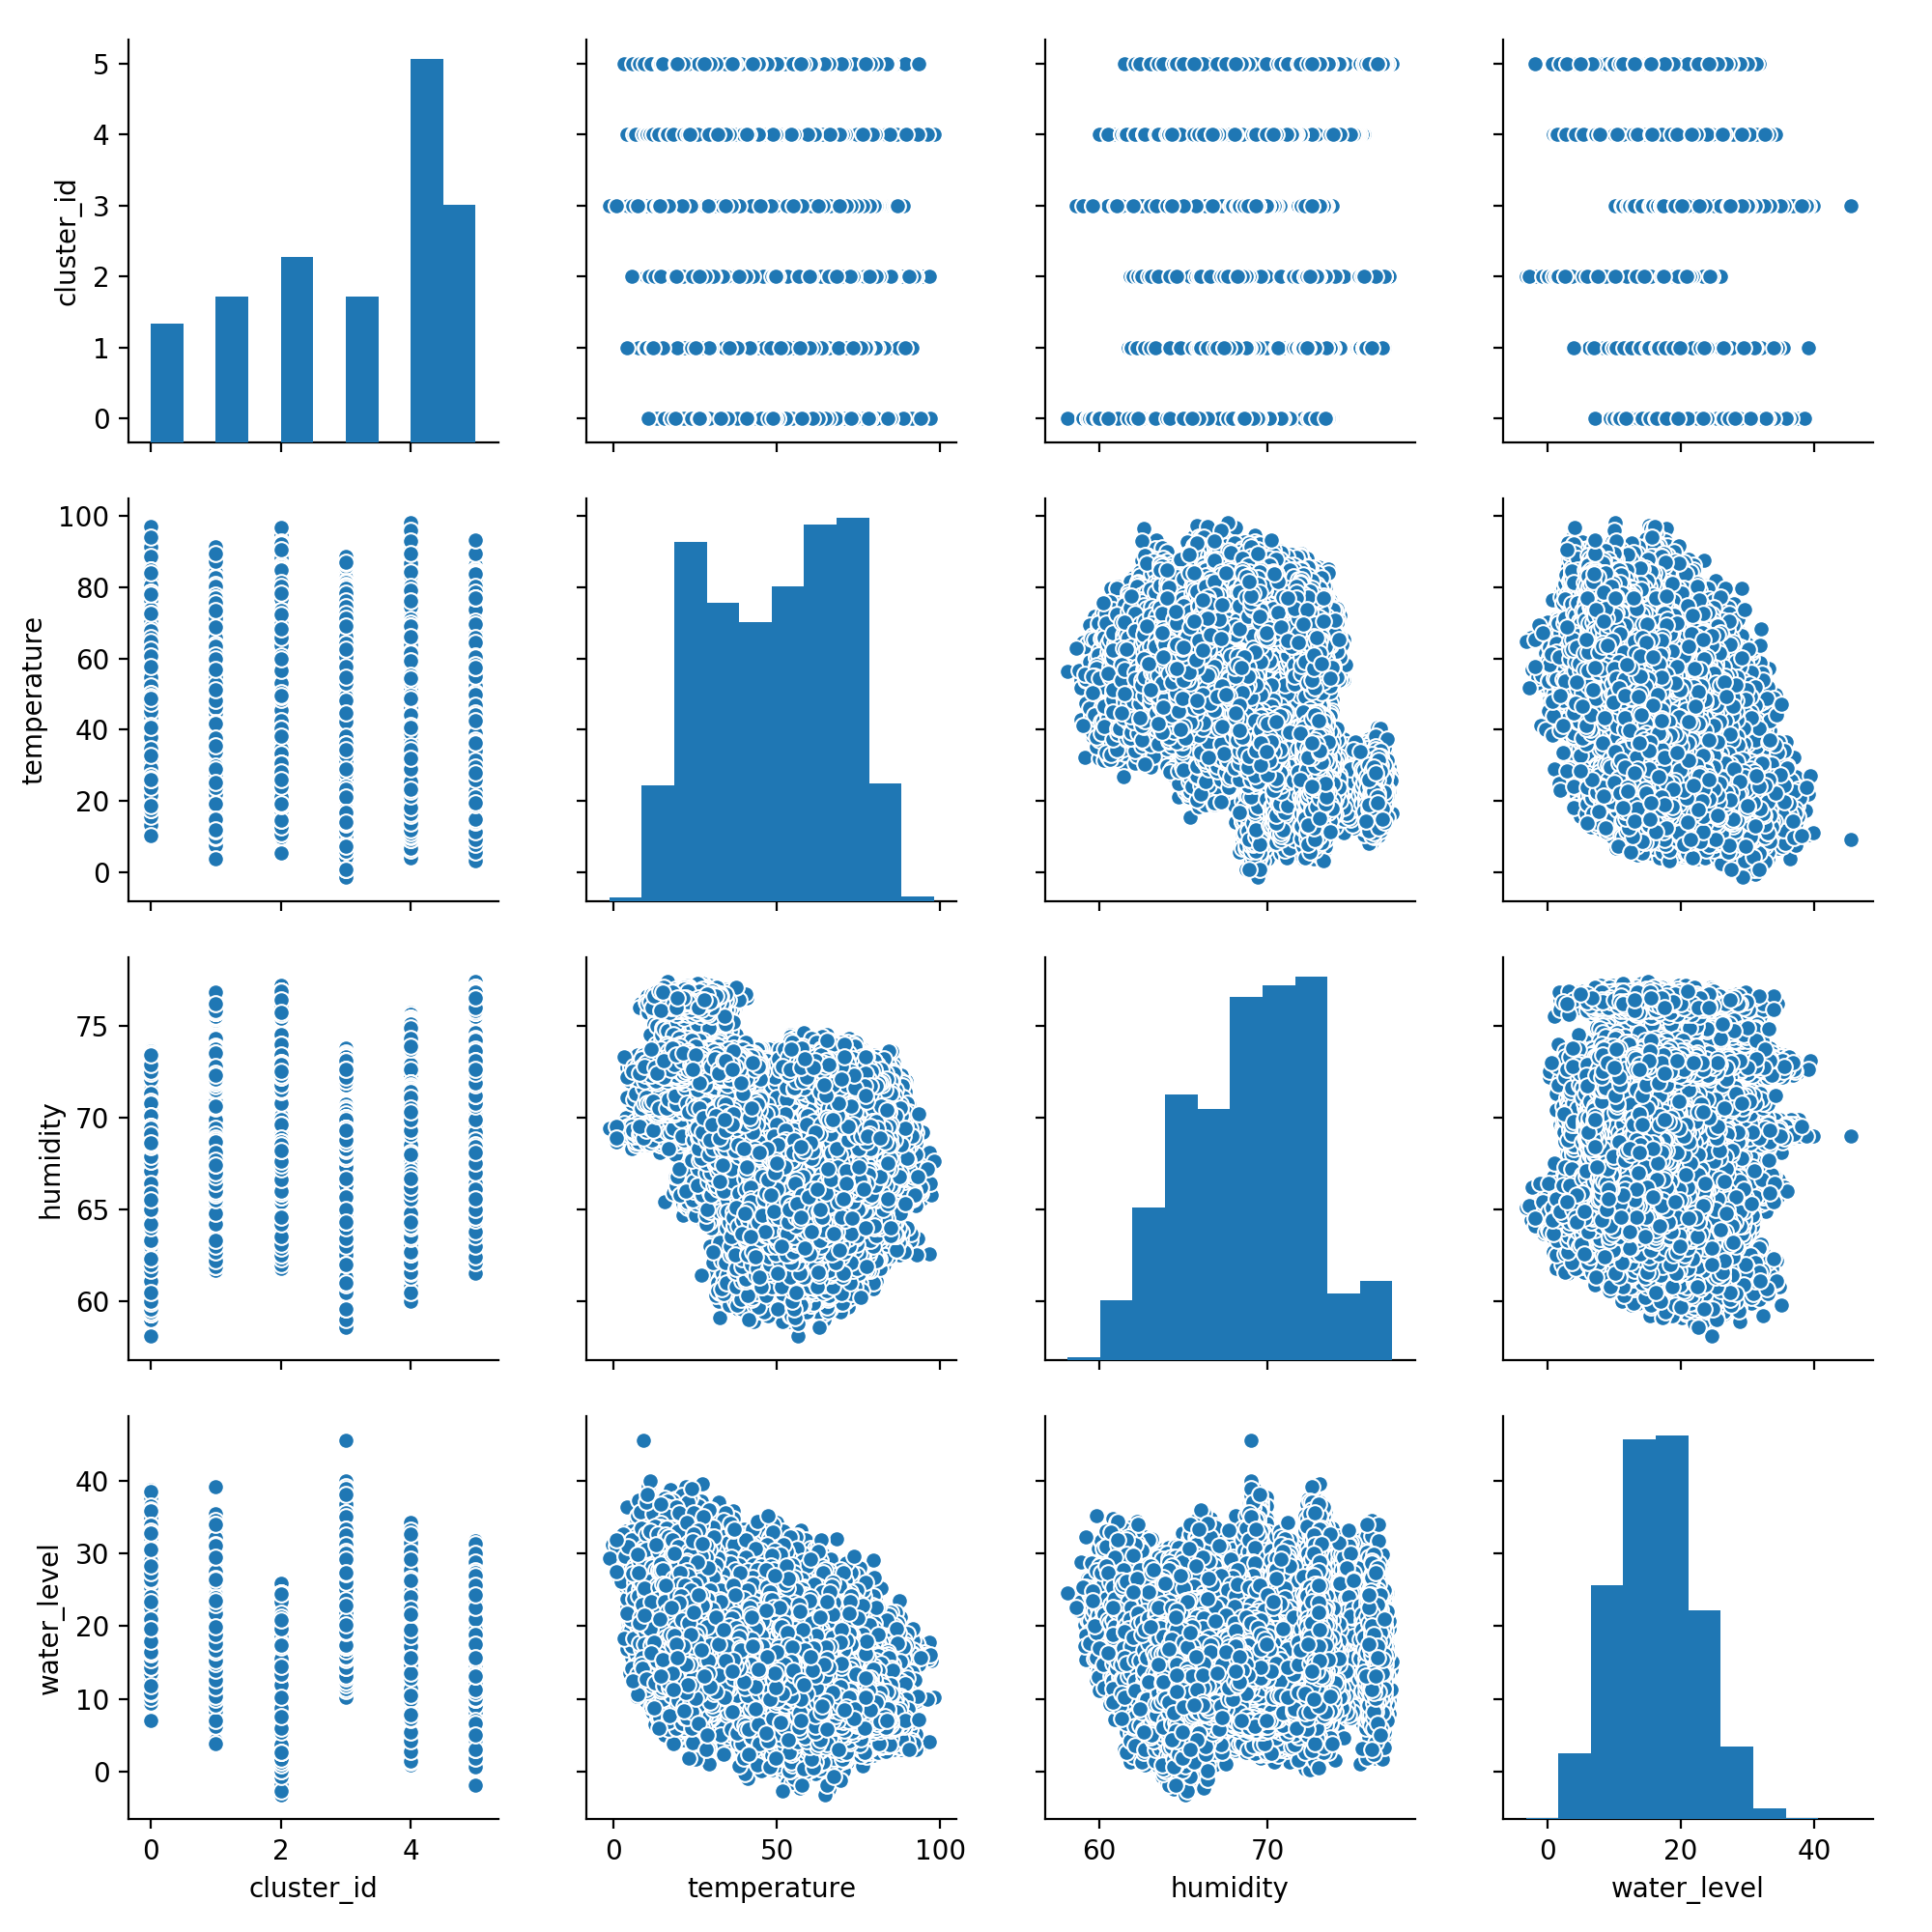

In [10]:
cols = ['cluster_id', 'temperature', 'humidity', 'water_level']
sns.pairplot(normal_df[cols])

### Water Level Plots

#### Box and Whisker Plot

In a box and whisker plot: the ends of the box are the upper and lower quartiles, so the box spans the interquartile range. the median is marked by a horizontal line inside the box. The whiskers are the two lines outside the box indicating variability outside the upper and lower quartiles. Outliers are plotted as individual points.

The plot shows what is normal changes from month to month. The summer months of June and July are relatively wet month from ground water level perspective presumably due to precipitations from earlier months. Maintaining reliable monthly water levels is critical to the agricultural needs.

In the visualizations, the gradual dataset shows a relatively bigger spread of the month of July.

<IPython.core.display.Javascript object>


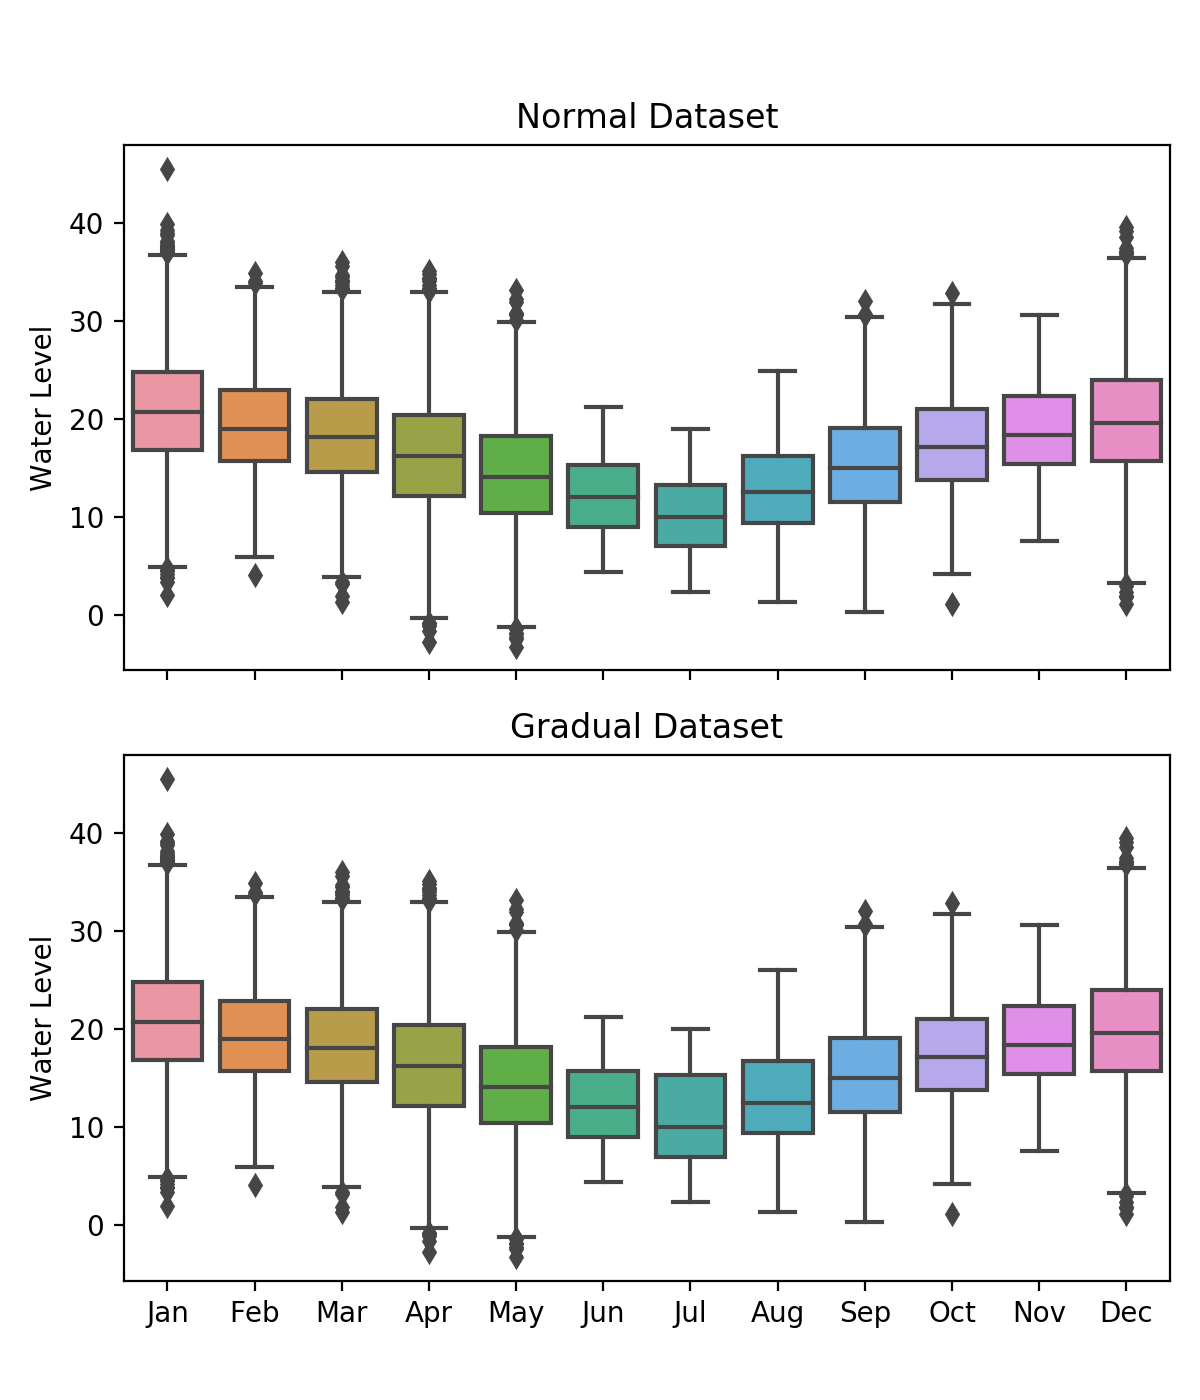

In [11]:
f, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(6, 7))

ax1 = sns.boxplot(x="month_name", y="water_level", data=normal_df, ax=axes[0])
ax2 = sns.boxplot(x="month_name", y="water_level", data=gradual_df, ax=axes[1])

ax1.set_title('Normal Dataset')
ax2.set_title('Gradual Dataset')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Water Level')
ax2.set_ylabel('Water Level')

f.tight_layout(rect=[0, 0.03, 1, 0.95])

### Daily Scatter Plot

Below you see a daily scatter plot of `Water Level` reading for years 2017-2019 for each of the 92 sensors (100,740 data points).

In this historic view of the data, you can observe the induced anomalies (around June-August 2019) in the gradual dataset.

In the following notebook we are going to develop an anomaly detection model that allows us to detect such anomalies in real-time.

<IPython.core.display.Javascript object>


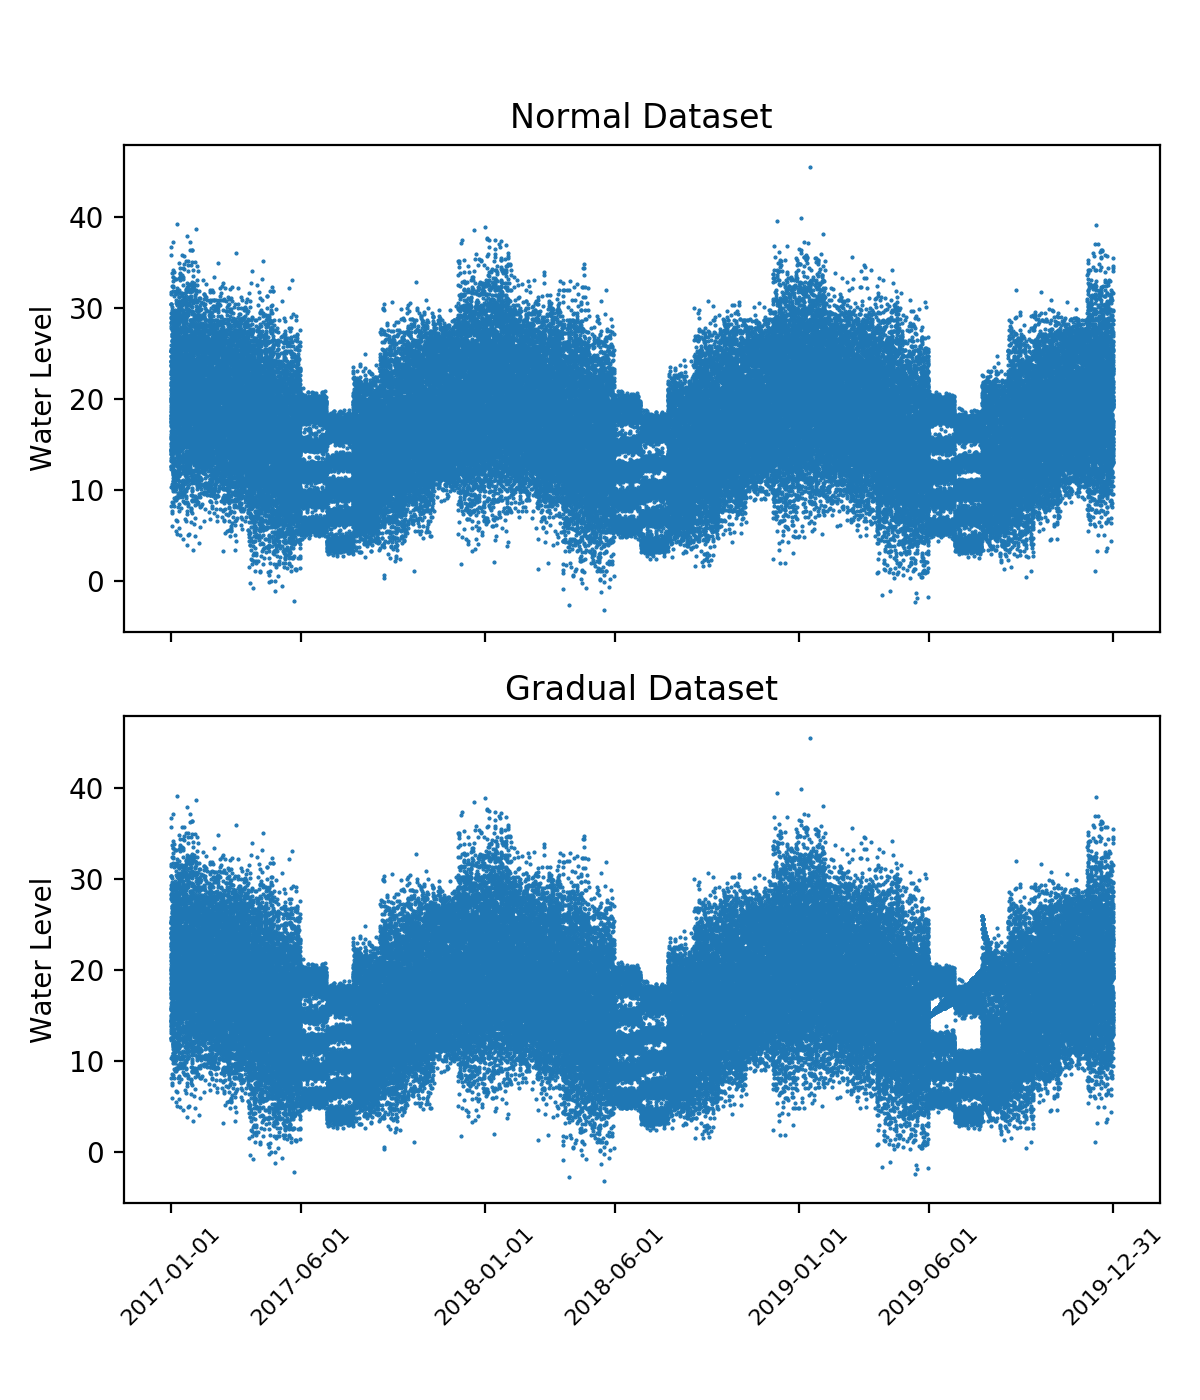

In [12]:
f, ax = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(6, 7))
ax[0].plot_date(gradual_df.date, normal_df.water_level, markersize=0.5)
ax[1].plot_date(gradual_df.date, gradual_df.water_level, markersize=0.5)
ax[0].set_title('Normal Dataset')
ax[1].set_title('Gradual Dataset')
ax[0].set_ylabel('Water Level')
ax[1].set_ylabel('Water Level')

ax[1].xaxis.set_ticks(['2017-01-01', '2017-06-01', '2018-01-01', '2018-06-01', 
                       '2019-01-01', '2019-06-01', '2019-12-31'])

plt.xticks(fontsize=8, rotation=45)
f.tight_layout(rect=[0, 0.03, 1, 0.95])